<a href="https://colab.research.google.com/github/BioWill25/NeuroscienceDAslides/blob/master/Will_neural_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cracking the neural code

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) # Nice big fonts
import warnings
warnings.filterwarnings("ignore") # Turn off distracting warning messages that you don't need to see
# Install quantities package, so that we can use units like mV, s, pA, etc and do dimensional analysis
!pip install -q quantities
import quantities as pq

In [0]:
# Make my dataframes big for slideshow mode
from IPython.display import HTML
HTML("""<style>
table.dataframe {
font-size:150%;
}
</style>""")

### What it looks like when we record the action potentials (spikes) of a neuron from inside the cell:

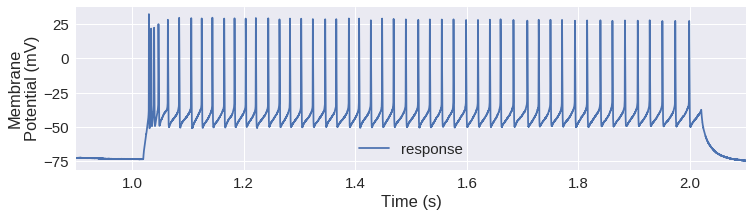

In [0]:
# Load data form the Allen Institute, saved from the previous lecture
url = "https://raw.githubusercontent.com/rgerkin/neuro-data-analysis-course/master/data/sample_trace.csv"
df = pd.read_csv(url, index_col=0) # index_col=0 means that the first column (time) should be the index

# Plot the cell's response (from the data frame column 'response') to the stimulus (not shown, but in column 'stimulus'), on a 12x3 canvas
df.plot(y='response', figsize=(12,3));

# Zoom the x-axis in to the interesting part, starting just before and ending just after the stimulus.  Label the axes.
plt.xlim(0.9, 2.1);
plt.xlabel('Time (s)')
plt.ylabel('Membrane\nPotential (mV)');

### What does it look like when we record the action potentials (spikes) from outside the neuron?

### - Current flows in loops (Kirchoff's laws)
### - $dV/dt = I/C$

![current-loops](https://raw.githubusercontent.com/rgerkin/neuro-data-analysis-course/master/images/current-loops.png)

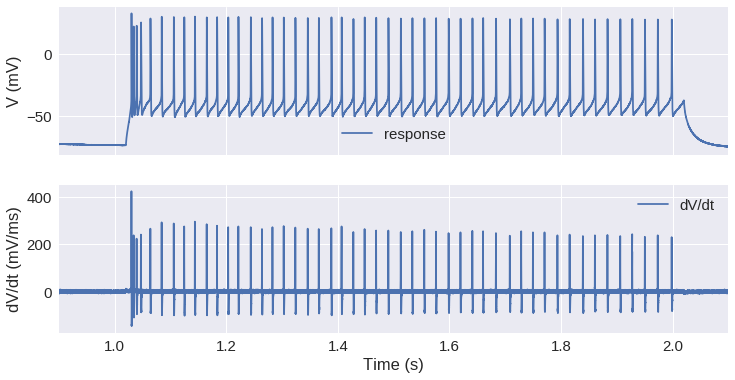

In [0]:
# This makes two linked plots that share an x-axis
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,6))

df.plot(y='response', ax=axes[0]) # Plot on the first set of axes
axes[0].set_xlim(0.9, 2.1);
axes[0].set_ylabel('V (mV)')

dt = (df.index[1] - df.index[0]) * pq.s
df['dV/dt'] = df['response'].diff() / dt.rescale('ms')
df.plot(y='dV/dt', ax=axes[1])
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('dV/dt (mV/ms)');

## Any current you record from outside the cell is the derivative (slope) of the voltage that you record inside the cell.

## This means we can still identify action potentials (spikes) by just putting an electrode somewhere near the cell.  

## What does that sound like?

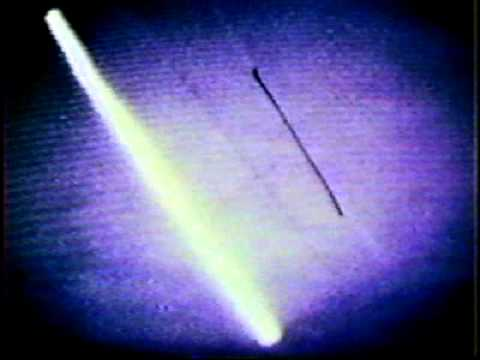

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo("8VdFf3egwfg")

In [0]:
def plot_raster(slope=1, spontaneous_rate=5, evoked_rate=20, n_trials=1):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].plot([0,1], [0,1*slope], linewidth=10)
    axes[0].axis('off')

    for trial in range(n_trials):
        spont_count = np.random.poisson(spontaneous_rate)
        evoked_count = np.random.poisson(evoked_rate)
        spont_spike_times = np.random.uniform(0, 3, size=spont_count)
        evoked_spike_times = np.random.uniform(1, 2, size=evoked_count)
        axes[1].plot(spont_spike_times, [trial]*len(spont_spike_times), '|k', linewidth=3)
        axes[1].plot(evoked_spike_times, [trial]*len(evoked_spike_times), '|r', linewidth=3)
    axes[0].axis('off')
    axes[1].set_xlim(0,3)
    axes[1].grid(False)
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Trial #')
    axes[1].set_yticks(range(n_trials));
    axes[1].set_yticklabels(range(1,n_trials+1));

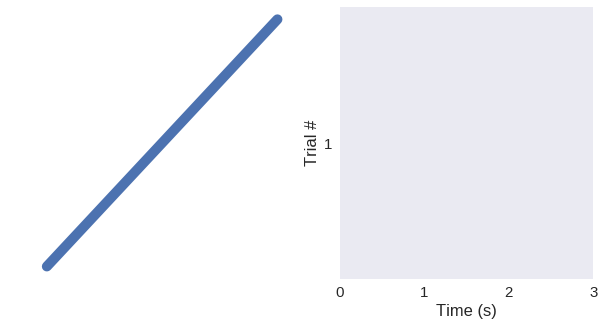

In [0]:
plot_raster(slope=1, spontaneous_rate=5, evoked_rate=20, n_trials=1)

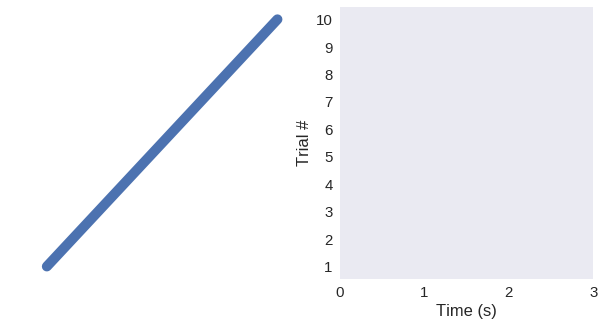

In [0]:
plot_raster(slope=1, spontaneous_rate=5, evoked_rate=20, n_trials=10)

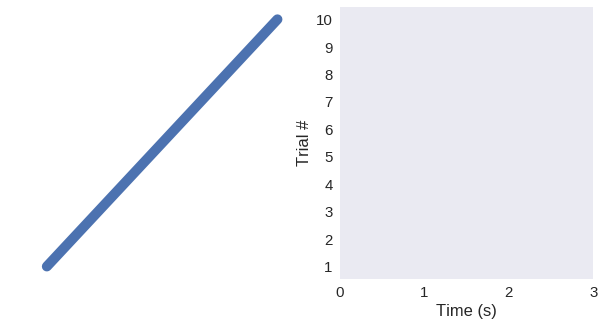

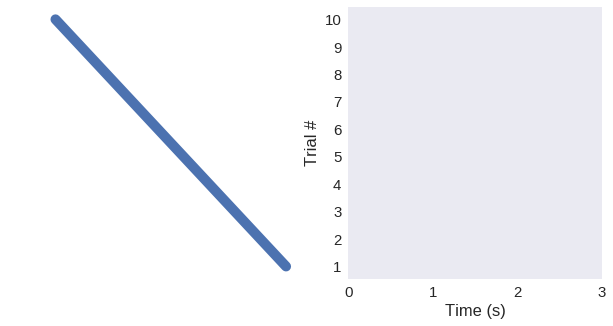

In [0]:
plot_raster(slope=1, spontaneous_rate=5, evoked_rate=20, n_trials=10)
plot_raster(slope=-1, spontaneous_rate=5, evoked_rate=0, n_trials=10)

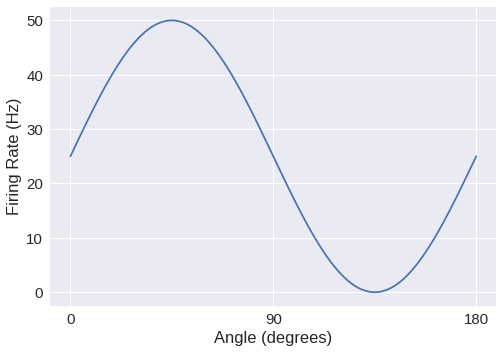

In [0]:
pi = np.pi # The mathematical constant "pi", i.e. 3.1415...
cos = np.cos # Cosine
angles = np.linspace(0, pi, 1000) # 1000 values from 0 to pi.  
spontaneous_rate = 25 # The baseline rate
evoked_rate = 25 # The change in rate at the preferred phase
peak_angle = pi/4 # The preferred phase
firing_rates = spontaneous_rate + evoked_rate*cos(2*(angles - peak_angle))
plt.plot(angles, firing_rates)
plt.xticks([0,pi/2,pi],[0,90,180]) # Show the x-axis in degrees instead of radians
plt.xlabel("Angle (degrees)")
plt.ylabel("Firing Rate (Hz)");

## The parts of "the world" that the cell responds to are called its "receptive field"

## How the cell responds to different scenarios in the world is called its "tuning curve"

![hubel-wiesel-direction](http://www.cns.nyu.edu/~david/courses/perception/lecturenotes/V1/LGN-V1-slides/Slide15.jpg)

![hubel-wiesel-motion](http://www.cns.nyu.edu/~david/courses/perception/lecturenotes/V1/LGN-V1-slides/Slide16.jpg)

![visual-cortex](https://raw.githubusercontent.com/rgerkin/neuro-data-analysis-course/master/images/visual-cortex.png)

## Receptive fields and tuned cells are everywhere in the brain

![monkey](https://raw.githubusercontent.com/rgerkin/neuro-data-analysis-course/master/images/monkey-motor.jpg)

![motor-tuning](https://raw.githubusercontent.com/rgerkin/neuro-data-analysis-course/master/images/motor-tuning-2.jpg)

## Analyses that come from these "neural codes"
### - What are the receptive fields and tuning curves of some recorded neurons?
### - Can we predict behavior if we know the above, plus the firing rates?
### - How much information (and what kind) does neuron activity contain about the outside world?

# The population vector

### - Suppose that, for each neuron, we summarize its activity as a single vector.
### - It's length is it's current firing rate, and it's direction is the neuron's preferred direction (previously measured).

In [0]:
def population_vectors(direction=7*pi/8, gain=3):
    fig = plt.figure(figsize=(12, 5))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122, projection='polar')
    ax2 = fig.add_subplot(122, frameon=False)
    angles = np.linspace(0,2*pi,1000)
    preferred_directions = {'blue':-pi/2, 'red':pi, 'green':pi/2}
    total_x, total_y = 0, 0
    for color, preferred_direction in preferred_directions.items():
        ax0.plot(angles, np.exp(gain*cos(angles-preferred_direction)), color)
        rate = np.exp(gain*cos(direction-preferred_direction))
        x = rate*np.cos(preferred_direction)
        y = rate*np.sin(preferred_direction)
        ax2.arrow(0, 0, x, y, lw=5, width=0.2, head_width=1, head_length=0.5, edgecolor=color, facecolor=color)
        total_x += x
        total_y += y
    ax2.arrow(0, 0, total_x, total_y, lw=5, width=0.2, 
              head_width=1, head_length=0.5, edgecolor='black', facecolor='black')
    ax0.set_xticks([0,pi/2,pi,3*pi/2])
    ax0.set_xticklabels([0,90,180,270]);
    ax0.set_xlabel('Direction of movement')
    ax0.set_ylabel('Firing Rate (Hz)');
    ax0.plot([direction, direction], [0, 20], 'k--')
    ax2.grid('off')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlim(-20,20)
    ax2.set_ylim(-10,10)

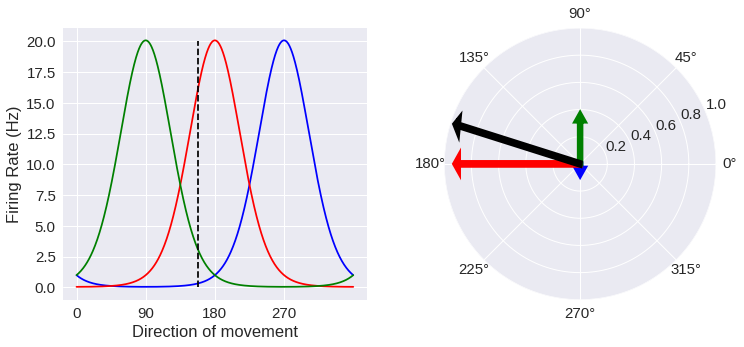

In [0]:
population_vectors() # Hypothetical data from neurons in the motor cortex

## Information

### - Information (I) is reduction of uncertainty
### - Entropy (H) is one way to measure uncertainty

### $H = -\sum{p_i*log_2(p_i)}$

### Entropy (H) is measured in bits

![coins](https://www.thesprucecrafts.com/thmb/C4QI9ouTUUOeaXx5H3Th6GLKNh0=/960x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/US0050-Kennedy-Half-Dollar-Example-Bus-Strk-xlg-56a178ce5f9b58b7d0bfa17a.jpg)

#### $ p(heads) = 0.5 $
#### $ p(tails) = 0.5 $

#### $H = - 0.5*log_2(0.5) - 0.5*log_2(0.5)$

#### $H =$ 1 bit

##### What if we found out something about the coins (like $p_{head} = 0.75$)

#### $ p(heads) = 0.75 $
#### $ p(tails) = 0.25 $
#### $H = - 0.75*log_2(0.75) - 0.25*log_2(0.25)$
#### $H =$ 0.811 bits

### $ I = H_{new} - H_{old} = 1 - 0.811 = 0.189$  bits of information